In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

## 1. Load train and test data from pickle

In [2]:
train = pd.read_pickle('../data/train.pkl')
test = pd.read_pickle('../data/test.pkl')

Drop the features not in the intersection set of train and test data. Drop the date column ('S_2').

In [3]:
train_to_drop_cols = [col for col in np.setdiff1d(train.columns.to_numpy(), test.columns.to_numpy()) if col != 'target']
test_to_drop_cols = np.setdiff1d(test.columns.to_numpy(), train.columns.to_numpy())

train.drop(columns=train_to_drop_cols, inplace=True)
test.drop(columns=test_to_drop_cols, inplace=True)

train.drop('S_2', axis=1, inplace=True)
test.drop('S_2', axis=1, inplace=True)

assert train.shape[1] == test.shape[1]+1

Drop customers that have less than n=13 rows

In [4]:
train = train[train.groupby('customer_ID')['customer_ID'].transform('count').ge(13)]
test = test[test.groupby('customer_ID')['customer_ID'].transform('count').ge(13)]

Separate X and y

In [5]:
train_X, train_Y = train.loc[:, train.columns!='target'], np.ravel(train[['customer_ID', 'target']].groupby('customer_ID').max())

assert train_X.shape == (train.shape[0], train.shape[1]-1)
assert train_Y.shape == (len(set(train['customer_ID'])),)

Aggregate features

In [6]:
CATEGORICAL_COLS = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']
NUMERICAL_COLS = [col for col in train_X.columns if col not in CATEGORICAL_COLS]

agg_features = ['mean', 'std', 'max', 'min']

In [7]:
train_X = train_X.groupby('customer_ID')[NUMERICAL_COLS].agg(agg_features)
train_X.columns = list(map('_'.join, train_X.columns.values))

test_X = test.groupby('customer_ID')[NUMERICAL_COLS].agg(agg_features)
test_X.columns = list(map('_'.join, test_X.columns.values))

assert train_X.shape[0] == train_Y.shape[0]
assert train_X.columns.tolist() == test_X.columns.tolist()
assert train_X.columns[train_X.isna().any()].tolist() == []
assert test_X.columns[test_X.isna().any()].tolist() == []

## 2. Feature Selection

In [10]:
train_X.shape

(386034, 520)

In [9]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [13]:
pca = PCA(n_components=150)
train_X = pca.fit_transform(train_X)
test_X = pca.transform(test_X)

assert train_X.shape[1] == test_X.shape[1]

print('Explained Var Ratio:', sum(pca.explained_variance_ratio_))

Explained Var Ratio: 0.9036673408552985


## 3. Training

In [14]:
def train_and_cv(model, n_fold=3):
  cv_score = np.mean(cross_val_score(model, train_X, train_Y, scoring='balanced_accuracy', cv=n_fold, n_jobs=-1))

  model.fit(train_X, train_Y)
  train_score = balanced_accuracy_score(train_Y, model.predict(train_X))

  print('train score: {0}, cross_val score: {1}'.format(train_score, cv_score))

In [27]:
def tune_hyper(model, model_name, param, p_range):
  train_scores, test_scores = validation_curve(model, train_X, train_Y, param_name=param, param_range=p_range, cv=3, scoring="balanced_accuracy", n_jobs=-1)
  train_mean = np.mean(train_scores, axis=1)
  train_std = np.std(train_scores, axis=1)
  test_mean = np.mean(test_scores, axis=1)
  test_std = np.std(test_scores, axis=1)

  plt.title('Validation Curve with {0}'.format(model_name))
  plt.xlabel(param)
  plt.ylabel("balanced_accuracy")
  plt.ylim(0.0, 1.1)

  plt.plot(p_range, train_mean, label="Train acc", color="darkorange")
  plt.fill_between(p_range, train_mean-train_std, train_mean+train_std, alpha=0.2, color="darkorange")
  plt.plot(p_range, test_mean, label="Val acc", color="navy")
  plt.fill_between(p_range, test_mean-test_std, test_mean+test_std, alpha=0.2, color="navy")
  plt.legend(loc="best")

  print(train_mean)
  print(test_mean)

In [ ]:
def grid_search(model, param_space):
  GridSearchCV(model, param_space, n_jobs=-1, cv=3, scoring="balanced_accuracy")

### 3.1. Baseline models

#### 3.1.a. Logistic Regression

In [16]:
train_and_cv(LogisticRegression(max_iter=500, n_jobs=-1))

train score: 0.8432665061695632, cross-val score: 0.8429986210628929


#### 3.1.b. Decision Tree

[0.84615937 0.82575573 0.86790182 0.94581476 0.98153671 0.99119527]
[0.84597514 0.82317787 0.8203283  0.80233246 0.79102786 0.78535988]


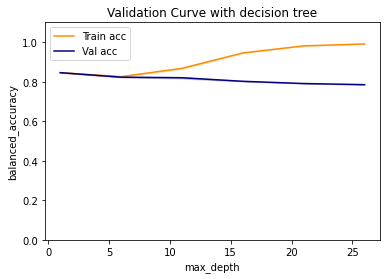

In [28]:
tune_hyper(DecisionTreeClassifier(), 'decision tree', 'max_depth', range(1, 31, 5))

In [59]:
train_and_cv(DecisionTreeClassifier(max_depth=6))

train score: 0.8210066405409503, val score: 0.8160797277897157


### 3.2. Ensemble models

#### 3.2.a. Random Forest

[0.49999916 0.745015   0.84480437 0.92320522 0.96756894 0.98332551]
[0.50000559 0.74129267 0.81995399 0.83653084 0.84171807 0.84337418]


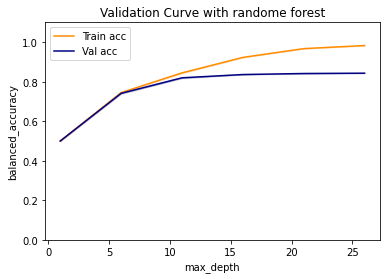

In [29]:
tune_hyper(RandomForestClassifier(n_jobs=-1), 'randome forest', 'max_depth', range(1, 31, 5))

[0.9996721  0.99997206 0.99999721 1.         1.        ]
[0.83815956 0.84372833 0.84591167 0.84633656 0.84710553]


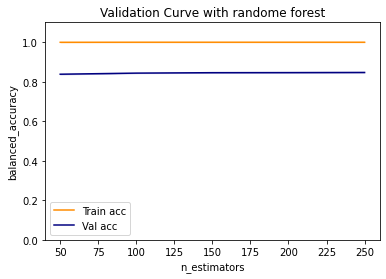

In [23]:
tune_hyper(RandomForestClassifier(n_jobs=-1), 'randome forest', 'n_estimators', range(50, 300, 50))

In [31]:
train_and_cv(RandomForestClassifier(max_depth=10, n_jobs=-1))

train score: 0.8267057450095505, cross-val score: 0.8126864577413345


#### 3.2.b. Gradient boosting

[0.82415723 0.87033753 0.98061674]
[0.82314256 0.85199491 0.85057297]


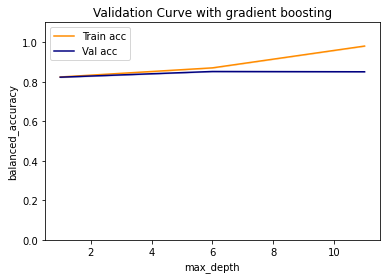

In [37]:
tune_hyper(GradientBoostingClassifier(), 'gradient boosting', 'max_depth', range(1, 16, 5))

[0.82286142 0.82952423 0.83256292 0.83447604 0.83600778 0.83719141]
[0.82155496 0.82751141 0.83016327 0.8316329  0.83248049 0.8333335 ]


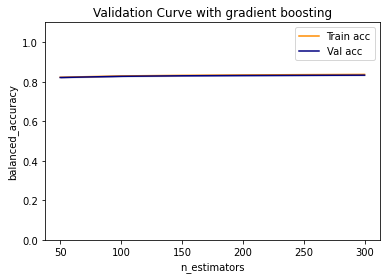

In [ ]:
tune_hyper(GradientBoostingClassifier(), 'gradient boosting', 'n_estimators', range(50, 301, 50))

[0.82295606 0.82952423 0.83773202]
[0.8215064  0.82751141 0.8322451 ]


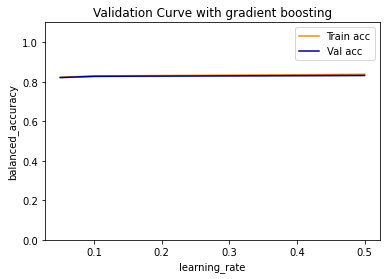

In [ ]:
tune_hyper(GradientBoostingClassifier(), 'gradient boosting', 'learning_rate', [0.05, 0.1, 0.5])

In [77]:
train_and_cv(GradientBoostingClassifier(max_depth=6))

train score: 0.8464813674590892, val score: 0.8368470426479965


#### 3.2.c. Adaboost

[0.80629821 0.81195014 0.81494776 0.81709099]
[0.80565337 0.81114462 0.81365218 0.81590863]


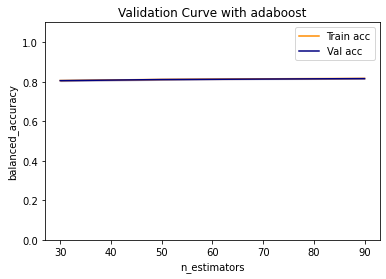

In [ ]:
tune_hyper(AdaBoostClassifier(), 'adaboost', 'n_estimators', range(30, 100, 20))

[0.7581959  0.78513617 0.81150276]
[0.75785706 0.78445147 0.81058039]


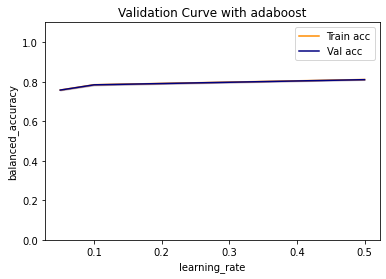

In [ ]:
tune_hyper(AdaBoostClassifier(), 'adaboost', 'learning_rate', [0.05, 0.1, 0.5])

In [35]:
train_and_cv(AdaBoostClassifier())

train score: 0.831821345072637, cross-val score: 0.8313849062473567


In [20]:
train_and_cv(AdaBoostClassifier(base_estimator=LogisticRegression()))

train score: 0.8371889178920433, cross-val score: 0.837215846197953


#### 3.2.d. XGBoost

[0.83749578 0.8935804  0.99998882]
[0.83613944 0.84893907 0.845271  ]


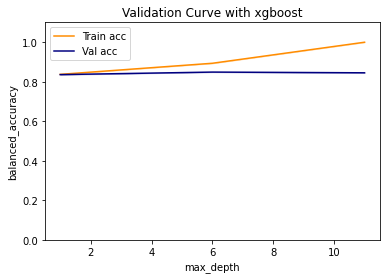

In [36]:
tune_hyper(XGBClassifier(), 'xgboost', 'max_depth', range(1, 16, 5))

In [83]:
train_and_cv(XGBClassifier(max_depth=6))

train score: 0.855356389931029, val score: 0.8352943490939791


### 3.3 Neural Network

In [ ]:
mlp_gs = MLPClassifier()
parameter_space = {
    'hidden_layer_sizes': [(20,), (40,), (60,), (80,), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=-1, cv=3)
clf.fit(train_X, train_Y) # X is train samples and y is the corresponding labels

In [34]:
train_and_cv(MLPClassifier())

train score: 0.892480635336887, cross-val score: 0.8434762086432569


### Comparison of the models
#### Baseline models

| Model                    | Train Acc| CV Acc|
| -----------              | ---------| ------|
| LogReg(max_iter=500)     | 0.843    | 0.843 |
| DecesionTree(max_depth=6)| 0.821    | 0.816 |

#### Ensemble models

| Model                        | Train Acc| CV Acc|
| -----------                  | ---------| ------|
| RandomForest(max_depth=6)    | 0.827    | 0.813 |
| GradientBoosting(max_depth=6)| 0.846    | 0.837 |
| AdaBoost(estimator=tree)     | 0.832    | 0.831 |
| AdaBoost(estimator=logreg)   | 0.837    | 0.837 |
| XGBoost(max_depth=6)         | 0.855    | 0.835 |

#### Neural Network

| Model                    | Train Acc| CV Acc|
| -----------              | ---------| ------|
| MLP                      | 0.838    | 0.846 |

## 4. Predict

In [ ]:
# TODO
model = LogisticRegression()

pred = model.predict(test_X)

df_result = pd.DataFrame({'customer_ID': test_X.index.tolist(), 'prediction': pred})
df_result.to_csv('../data/result.csv', index=False)